# Develop a complete python web-app

The goal of this exercise is to develop the raw prototype code presented below into a full fledged python web-app. 

The code below extracts historical spot-auction power price data for several pricing areas. 
A subset of this data (specified in terms of training period and columns) is used to train one or more models to predict
the spot price for a specified target column over a chosen test period. 
Refactor the code as necessary to convert into production quality code. 

The web-app should adhere to a RESTful API architecture as much as possible and may be developed in Flask. 
There should be a way to train a model on an arbitrarily chosen column over a select time period, and retrieve the prediction from the application.
For example, when deployed locally, it should be possible to train the model with a command such as:

```
# train a model to predict prices for France
>>> import requests
>>> p = {'features':['DE-LU', 'NL', 'BE']}
>>> requests.get("localhost:1234/api/train?model=random_forest&target=FR&train_from=20200101&train_to=20200301", params=p)

# predict prices for France
>>> requests.get("localhost:1234/api/predict?model=random_forest&target=FR&test_from=20200302&test_to=20200315")
```

All the relevant code should be properly packaged in accordance with good python design principles.
The application will ideally be deployed on Kubernetes using Docker containers through AzureDevOps. 
If you are comfortable with the technologies feel free to include the necessary config files (DockerFile, deployment.yaml, pipeline.yaml etc..).

**NOTE: The main goal here is to develop a well-rounded web-app and not to construct the best forecasting model.**

Please return the packaged code to GOPAM@orsted.dk as a zipped folder.

In [1]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso

In [2]:
# get data
df_2020 = pd.read_html(
    "https://www.nordpoolgroup.com/4adabc/globalassets/marketdata-excel-files/elspot-prices_2020_hourly_eur.xls",
    decimal=",", thousands="."
)[0]
df_2020.columns = [c[-1] for c in df_2020.columns]
df_2020 = df_2020.rename(columns={"Unnamed: 0_level_2": "Date"})

df_2019 = pd.read_html(
    "https://www.nordpoolgroup.com/4adabc/globalassets/marketdata-excel-files/elspot-prices_2019_hourly_eur.xls",
    decimal=",", thousands="."
)[0]
df_2019.columns = [c[-1] for c in df_2019.columns]
df_2019 = df_2019.rename(columns={"Unnamed: 0_level_2": "Date"})

df = df_2019.append(df_2020)

In [3]:
df = df_2019.append(df_2020)

In [4]:
# fill nans
for col in df:
    if f"{col}.1" in df.columns:
        df[col] = df[col].fillna(df[f"{col}.1"])
        df = df.drop(f"{col}.1", axis=1)
df = df.dropna().reset_index(drop=True)

In [5]:
# I want to predict the price for one country knowing all the other prices
target = "FR"
train_share = 0.8

In [6]:
x_train = df.drop([target, "Date", "Hours"], axis=1).iloc[:int(train_share * len(df))]
x_test = df.drop([target, "Date", "Hours"], axis=1).drop(x_train.index, axis=0)
y_train = df[target].reindex(x_train.index)
y_test = df[target].reindex(x_test.index)

In [10]:
models = {
    "random_forest": RandomForestRegressor(),
    "gradient_boosting": GradientBoostingRegressor(),
    "lasso": Lasso(),
    "regression": LinearRegression()
}

In [11]:
for md in models:
    models[md].fit(x_train, y_train)

In [12]:
predictions = pd.DataFrame(index=x_test.index)
for md in models:
    predictions[md] = models[md].predict(x_test)

<AxesSubplot:>

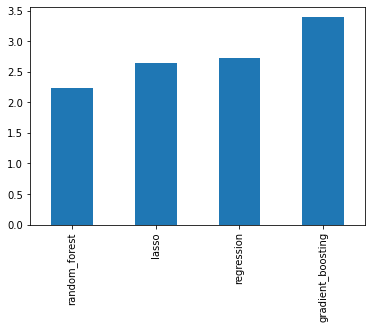

In [13]:
predictions.sub(y_test, axis=0).abs().mean().sort_values().plot.bar()